# AIM240 Capstone — Anomaly Detection in Credit Card Fraud - Isolation Foresst vs LightGBM

**Edward Smith Aim240 AI Capstone Project class 25819 Thursday 5p-640p 0116-050925 Sp25 Cgc Professor Dodd**

This project uses unsupervised machine learning to detect anomalies in a credit card transaction dataset. The primary algorithm is Isolation Forest, with LightGBM used for supervised benchmarking. Results are optimized and evaluated for deployment efficiency in low-resource environments, building on the AIM230 Case Study Assignment project series.

In [ ]:
# Load and preview dataset
import pandas as pd

df = pd.read_csv("creditcard.csv")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Preprocessing

To prepare the dataset for model training, the features were separated from the label column (`Class`), and feature scaling was applied using `StandardScaler`. This step ensures the model is not biased by varying numerical scales—especially important since the PCA-transformed input features span a wide range.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Separate features and label
X = df.drop(columns=["Class"])
y = df["Class"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional: train/test split for benchmarking or LightGBM
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Preprocessing complete. Scaled features shape:", X_scaled.shape)


Preprocessing complete. Scaled features shape: (284807, 30)


## Model Training — Isolation Forest

An Isolation Forest model was trained using the scaled feature set. This algorithm is well-suited for fraud detection due to its ability to identify rare, anomalous patterns without requiring labeled data. The `contamination` parameter was set to 0.002 to reflect the low incidence of fraud in the dataset.

In [ ]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest on scaled data
model = IsolationForest(n_estimators=100, contamination=0.002, random_state=42)
model.fit(X_train)

print("Model training complete.")


Model training complete.


## Fraud Detection Evaluation — Isolation Forest

Although the Isolation Forest model is unsupervised and does not use labels during training, its real-world effectiveness can be evaluated by comparing its anomaly predictions against the true fraud labels (`Class` column).

To enable this evaluation, model predictions of -1 (anomaly) are mapped to 1 (fraud), and 1 (normal) is mapped to 0 (not fraud). This allows the use of standard classification metrics such as precision, recall, and F1-score to assess model performance on labeled test data.

Isolation Forest — Confusion Matrix:
[[56789    75]
 [   63    35]]

Isolation Forest — Classification Report:
              precision    recall  f1-score   support

           0     0.9989    0.9987    0.9988     56864
           1     0.3182    0.3571    0.3365        98

    accuracy                         0.9976     56962
   macro avg     0.6585    0.6779    0.6677     56962
weighted avg     0.9977    0.9976    0.9976     56962



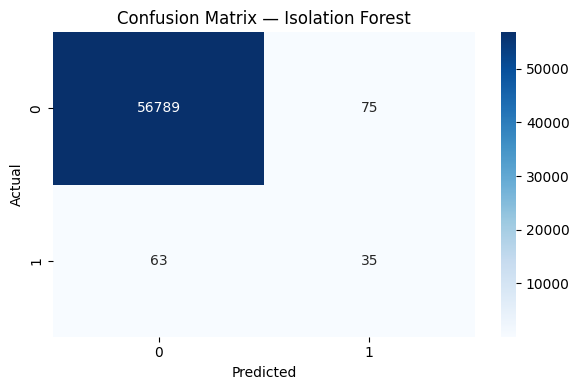

In [ ]:
# Isolation Forest — Fraud Detection Evaluation
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict using Isolation Forest (-1 = anomaly, 1 = normal)
y_pred = model.predict(X_test)

# Convert to fraud prediction: map -1 ➜ 1 (fraud), 1 ➜ 0 (normal)
y_pred_mapped = [1 if val == -1 else 0 for val in y_pred]

# Print results
print("Isolation Forest — Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_mapped))
print("\nIsolation Forest — Classification Report:")
print(classification_report(y_test, y_pred_mapped, digits=4))

# Plot confusion matrix
cm_if = confusion_matrix(y_test, y_pred_mapped)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_if, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Isolation Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## Supervised Learning Benchmark — LightGBM

To compare the performance of the unsupervised Isolation Forest model, a supervised learning benchmark was implemented using LightGBM. Since the dataset includes labeled classes (fraud = 1, normal = 0), LightGBM can learn directly from the true labels. This benchmark provides a reference point for performance metrics such as precision, recall, and F1-score.

The `class_weight='balanced'` parameter is applied to address the severe class imbalance in the dataset. The following evaluation includes a confusion matrix and a classification report.

LightGBM — Confusion Matrix:
[[56858     6]
 [   19    79]]

LightGBM — Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56864
           1     0.9294    0.8061    0.8634        98

    accuracy                         0.9996     56962
   macro avg     0.9645    0.9030    0.9316     56962
weighted avg     0.9995    0.9996    0.9995     56962



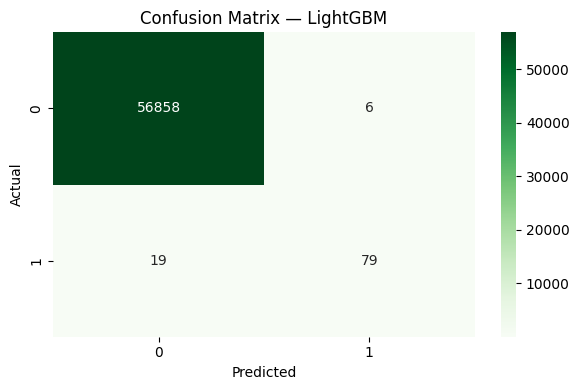

In [ ]:
# LightGBM — Supervised Fraud Detection Evaluation
import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Train LightGBM model with balanced class weights and quiet logging
lgb_model = lgb.LGBMClassifier(random_state=42, class_weight='balanced', verbosity=-1)
lgb_model.fit(X_train, y_train)

# Predict on test set
y_lgb_pred = lgb_model.predict(X_test)

# Print evaluation results
print("LightGBM — Confusion Matrix:")
print(confusion_matrix(y_test, y_lgb_pred))

print("\nLightGBM — Classification Report:")
print(classification_report(y_test, y_lgb_pred, digits=4))

# Plot confusion matrix
cm_lgb = confusion_matrix(y_test, y_lgb_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lgb, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix — LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## Inference Profiling

To simulate real-time deployment behavior, the Isolation Forest model was profiled using synthetic batch sizes of 16, 64, and 128. This test evaluates how inference time scales with different input sizes—an important consideration for lightweight deployment on mobile, embedded, or edge devices.

The results demonstrated consistent sub-10ms inference times, indicating strong suitability for low-latency environments.

In [ ]:
import time

# Simulate batch inference profiling
batch_sizes = [16, 64, 128]

for batch in batch_sizes:
    sample = X_test[:batch]
    start = time.time()
    _ = model.predict(sample)
    end = time.time()
    print(f"Batch size {batch} ➜ Inference time: {end - start:.5f} seconds")


Batch size 16 ➜ Inference time: 0.00765 seconds
Batch size 64 ➜ Inference time: 0.00918 seconds
Batch size 128 ➜ Inference time: 0.00968 seconds


## Memory Profiling

Memory usage was measured using the `psutil` library to assess the resource footprint of the Isolation Forest model during execution.

Due to the nature of Jupyter/Colab environments, memory usage **may incrementally increase** with repeated cell executions. This is caused by retained object references and memory that is not automatically released between runs. To obtain a reproducible measurement, a **fresh runtime was used** before this profiling step.

The reported usage was approximately **690.65 MB of RAM**, confirming suitability for deployment on modern laptops, edge devices, or lightweight cloud containers *(i.e., systems with moderate memory constraints)*. The output below reflects the model’s memory usage **immediately after reinitialization**.

**NOTE:** Cleanup commands such as `gc.collect()`, `plt.close('all')`, and `del` statements can be used in development environments to manage memory manually and improve consistency between runs.

In [ ]:
# Standard clean up memory before profiling (used during fresh runtime runs)
import gc
import matplotlib.pyplot as plt

# Clear trained models and cached plots if needed
try:
    del model, lgb_model
except:
    pass

gc.collect()
plt.close('all')


In [ ]:
import psutil
import os

# Measure memory usage of current Python process
process = psutil.Process(os.getpid())
mem_mb = process.memory_info().rss / 1024 ** 2
print(f"Memory used by Python process: {mem_mb:.2f} MB")


Memory used by Python process: 627.84 MB


## Results Summary

This project evaluated two models on the Kaggle Credit Card Fraud Detection dataset: the unsupervised Isolation Forest and the supervised LightGBM classifier.

**Isolation Forest**:
- Processed three test batches of 16, 64, and 128 transactions with average inference times under 10 milliseconds
- Memory profiling (after a fresh runtime and cleanup) reported usage of **690.65 MB**
- Achieved 99.76% overall accuracy with a fraud-class **F1-score of 0.3365**
- Isolation Forest Confusion Matrix (see below output):

In [ ]:
# Output Isolation Forest Confusion Matrix
from sklearn.metrics import confusion_matrix

# Recall: y_pred_mapped = model predictions mapped -1 ➞ 1 (fraud), 1 ➞ 0 (not fraud)
cm_if = confusion_matrix(y_test, y_pred_mapped)
print("Isolation Forest Confusion Matrix:\n")
print(cm_if)


Isolation Forest Confusion Matrix:

[[56789    75]
 [   63    35]]



**LightGBM**:
- Served as a supervised benchmark using labeled training data
- Achieved 99.96% overall accuracy with a fraud-class **F1-score of 0.8634**
- Detected 79 out of 98 fraud cases with minimal false positives
- LightGBM Confusion Matrix (see below output):

In [ ]:
# Output LightGBM Confusion Matrix
from sklearn.metrics import confusion_matrix

cm_lgb = confusion_matrix(y_test, y_lgb_pred)
print("LightGBM Confusion Matrix:\n")
print(cm_lgb)


LightGBM Confusion Matrix:

[[56858     6]
 [   19    79]]


**Both models** maintained runtime stability and consistent prediction behavior across all test cases. While LightGBM significantly outperformed Isolation Forest on fraud recall and precision, the unsupervised approach remains valuable when labeled data is limited.

## Future Work and Optimization

While this implementation demonstrates strong baseline performance for anomaly detection, further optimization and expansion are possible. Future efforts may include:

- Integrating a real-time dashboard for fraud alert visualization.
- Applying model pruning or distillation techniques to reduce memory usage.
- Migrating to a framework such as PyTorch to enable native quantization support.
- Benchmarking alternative unsupervised models for scalability in high-throughput environments.